In [1]:
import sympy as sm

In [2]:
import sympy.physics.mechanics as me

In [3]:
me.init_vprinting(use_latex=True, pretty_print=False)

In [4]:
m, r, g = sm.symbols('m, r, g')

In [5]:
q1, q2, q3, x, y = me.dynamicsymbols('q1, q2, q3, x, y')

In [6]:
u1, u2, u3, vx, vy = me.dynamicsymbols('u1, u2, u3, v_x, v_y')

# Reference Frames

In [7]:
N = me.ReferenceFrame('N')

In [8]:
Y = N.orientnew('Y', 'Axis', (q1, N.z))

In [9]:
L = Y.orientnew('L', 'Axis', (q2, Y.y))

In [10]:
R = L.orientnew('R', 'Axis', (q3, L.x))

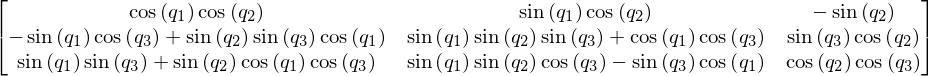

In [11]:
sm.trigsimp(R.dcm(N))

In [12]:
#R = N.orientnew('R', 'Body', (q1, q2, q3), 'ZYX')

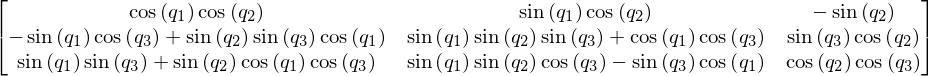

In [13]:
R.dcm(N)

In [14]:
w_R_N_qd = R.ang_vel_in(N)
w_R_N_qd

In [15]:
R.set_ang_vel(N, u1 * L.x + u2 * L.y + u3 * L.z)

In [16]:
kd = [me.dot(R.ang_vel_in(N) - w_R_N_qd, uv) for uv in L]

In [17]:
kd = kd + [vx - x.diff(), vy - y.diff()]

In [18]:
kd

In [19]:
qdots = sm.solve(kd, q1.diff(), q2.diff(), q3.diff(),
                 x.diff(), y.diff())

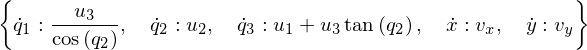

In [20]:
qdots

In [21]:
No = me.Point('No')
No.set_vel(N, 0)

In [22]:
C = No.locatenew('C', x * N.x + y * N.y)

In [23]:
C.set_vel(N, vx * N.x + vy * N.y)

In [24]:
Ro = C.locatenew('Ro', r * L.z)

In [25]:
v_Ro_N = Ro.v2pt_theory(C, N, L)
v_Ro_N

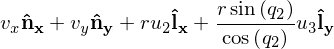

In [26]:
v_Ro_N.subs(qdots)

In [27]:
Ro.set_vel(N, v_Ro_N.subs(qdots))

In [28]:
Ro.a2pt_theory(C, N, L)

In [29]:
qddots = {k.diff(): v.diff(me.dynamicsymbols._t).subs(qdots)
          for k, v in qdots.items()}

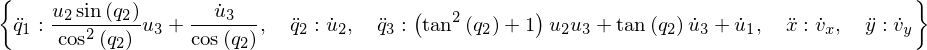

In [30]:
qddots

In [31]:
a_Ro_N = Ro.a2pt_theory(C, N, L)

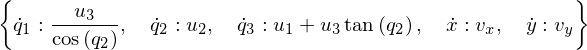

In [32]:
qdots

In [33]:
a_Ro_N

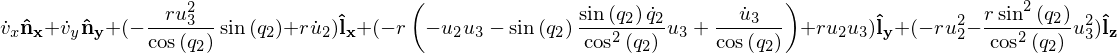

In [34]:
a_Ro_N.subs(qdots)

In [35]:
Ro.set_acc(N, a_Ro_N.subs(qddots).subs(qdots))

# Velocity constraints

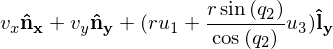

In [36]:
v_C_N = C.v2pt_theory(Ro, N, R)
v_C_N

In [37]:
con1 = v_C_N.dot(Y.x)
con1

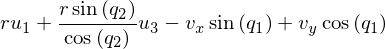

In [38]:
con2 = v_C_N.dot(Y.y)
con2

In [39]:
vel_cons = [con1, con2]

In [40]:
dep_speeds = sm.solve(vel_cons, vx, vy)
dep_speeds

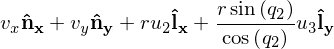

In [41]:
Ro.vel(N)

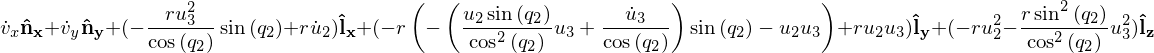

In [42]:
Ro.acc(N)

In [43]:
R.ang_vel_in(N)

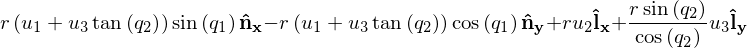

In [44]:
Ro.set_vel(N, Ro.vel(N).subs(dep_speeds))
Ro.vel(N)

In [45]:
t = me.dynamicsymbols._t

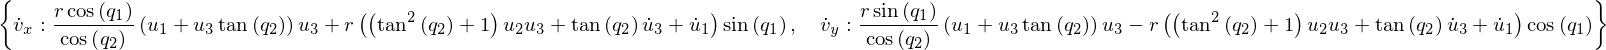

In [46]:
dep_accs = {k.diff(): v.diff(t).subs(qdots) for k, v in dep_speeds.items()}
dep_accs

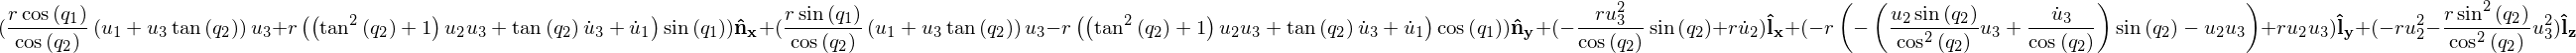

In [47]:
Ro.set_acc(N, Ro.acc(N).subs(dep_accs).subs(dep_speeds))
Ro.acc(N)

In [48]:
loads = [(Ro, -m * g * N.z)]

In [49]:
I = me.inertia(L, m / 4 * r**2, m / 2 * r**2, m / 4 * r**2)

In [50]:
disc = me.RigidBody('disc', Ro, R, m, (I, Ro))

In [51]:
bodies = [disc]

In [52]:
kane = me.KanesMethod(N,
                      q_ind=(q1, q2, q3, x, y),
                      u_ind=(u1, u2, u3),
                      kd_eqs=kd,
                      u_dependent=(vx, vy),
                      velocity_constraints=vel_cons)

In [53]:
fr, frstar = kane.kanes_equations(bodies, loads)

In [54]:
fr.shape

In [55]:
frstar.shape

In [56]:
me.find_dynamicsymbols(fr)

In [57]:
me.find_dynamicsymbols(frstar)

In [58]:
zero = sm.trigsimp(fr + frstar)

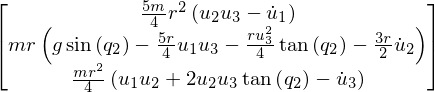

In [59]:
zero

In [60]:
u = sm.Matrix([u1, u2, u3])

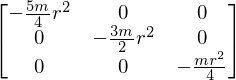

In [61]:
M = zero.jacobian(u.diff())
M

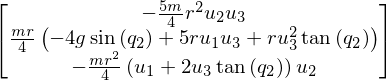

In [62]:
G = sm.simplify(M * u.diff() - zero)
G

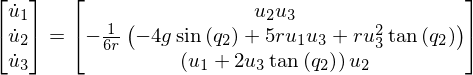

In [63]:
udots = M.LUsolve(G)
sm.Eq(u.diff(), udots)

In [64]:
me.find_dynamicsymbols(udots)

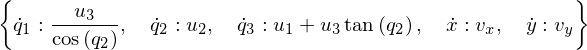

In [65]:
qdots

In [66]:
dep_speeds

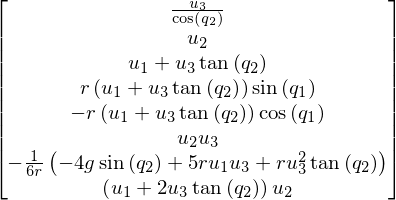

In [67]:
xdots = sm.Matrix([qdots[q1.diff()], qdots[q2.diff()], qdots[q3.diff()]]).\
        col_join(sm.Matrix([dep_speeds[vx], dep_speeds[vy]])).\
        col_join(udots)
xdots

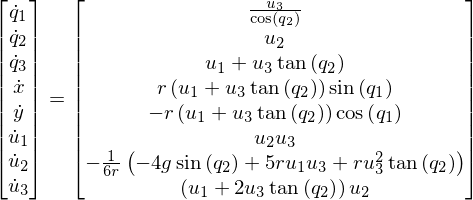

In [68]:
sm.Eq(sm.Matrix([q1.diff(), q2.diff(), q3.diff(), x.diff(), y.diff(),
                 u1.diff(), u2.diff(), u3.diff()]), xdots)

In [69]:
from scipy.integrate import odeint

In [70]:
odeint?

In [71]:
from pydy.codegen.ode_function_generators import generate_ode_function

In [72]:
generate_ode_function?

In [73]:
eval_xdot = generate_ode_function(xdots, [q1, q2, q3, x, y], [u1, u2, u3], [m, r, g])

In [74]:
type(eval_xdot)

function

In [75]:
eval_xdot?

In [76]:
import numpy as np

In [77]:
x_test = np.random.random(8)

In [78]:
x_test

array([ 0.73376582,  0.55565855,  0.45365692,  0.90522437,  0.31946384,
        0.59363532,  0.37053571,  0.21394183])

In [79]:
p_test = np.array([1.0, 1.0, 9.81])

In [80]:
eval_xdot(x_test, 2.6, p_test)

array([ 0.25182863,  0.37053571,  0.72647565,  0.48649975, -0.53952282,
        0.07927309,  3.33929602,  0.31840726])

In [81]:
%timeit eval_xdot(x_test, 2.6, p_test)

114 µs ± 10.8 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [82]:
eval_xdot_c = generate_ode_function(xdots, [q1, q2, q3, x, y], [u1, u2, u3], [m, r, g],
                                    generator='cython')

In [83]:
%timeit eval_xdot_c(x_test, 2.6, p_test)

20.7 µs ± 243 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [84]:
times = np.linspace(0, 20.0, num=1000)

In [85]:
x0 = np.array([0, np.deg2rad(1), 0, 0, 0, 0, 0, np.deg2rad(100)])

In [86]:
traj = odeint(eval_xdot, x0, times, args=(p_test, ))

In [87]:
(p_test)

array([ 1.  ,  1.  ,  9.81])

In [88]:
(p_test, )

(array([ 1.  ,  1.  ,  9.81]),)

In [89]:
type((p_test, ))

tuple

In [90]:
import matplotlib.pyplot as plt

In [91]:
%matplotlib notebook

<IPython.core.display.Javascript object>


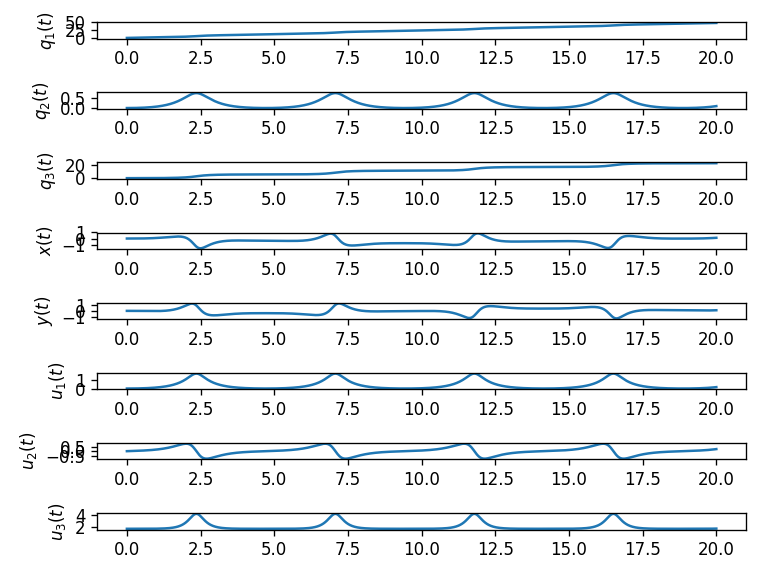

In [92]:
states = [q1, q2, q3, x, y, u1, u2, u3]
fig, axes = plt.subplots(8, 1)

for i, ax in enumerate(axes):
    ax.plot(times, traj[:, i])
    ax.set_ylabel(sm.latex(states[i], mode='inline'))
    
plt.tight_layout()

<IPython.core.display.Javascript object>


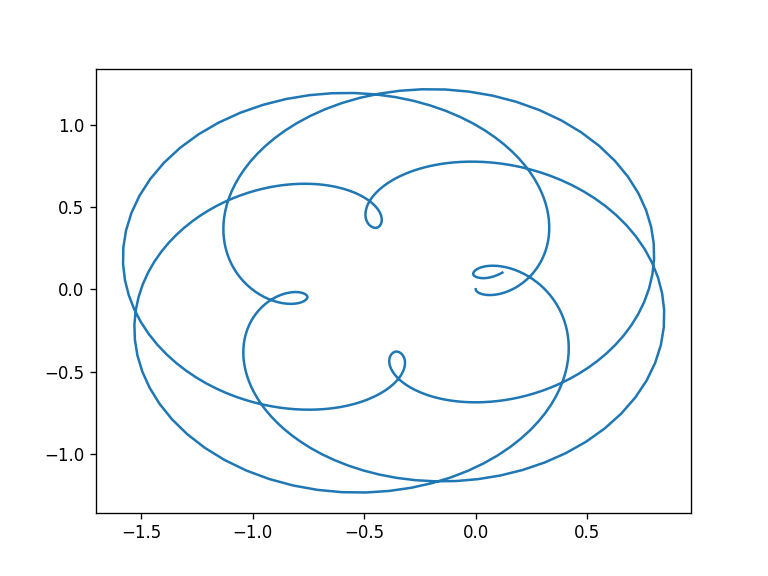

In [93]:
fig, ax = plt.subplots(1, 1)
ax.plot(traj[:, 3], traj[:, 4])